In [2]:
import html5lib
import requests
import lxml
from bs4 import BeautifulSoup
from bs4 import Comment
import pandas as pd
import numpy as np
from helpers import col_desc
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [3]:
# Get the roster table from the placeholder comment
def is_comment(element): 
    return isinstance(element, Comment)
url = 'https://www.baseball-reference.com/teams/ARI/2019.shtml'
html = requests.get(url).content
soup =  BeautifulSoup(html, 'html5lib')
roster = soup.find(attrs={'id':'all_the40man'}).find(text=is_comment)
man40 = pd.read_html(str(BeautifulSoup(roster).find(attrs={'id':'the40man'})))[0]

In [4]:
man40.head(3)

,Rk,Uni,Name,Unnamed: 3,Unnamed: 4,OnActv,IL,Age,B,T,Ht,Wt,DoB,1stYr
0,1,23,Zac Gallen,us US,Pitcher,*,NaN,23,R,R,"6' 2""",191,"Aug 3, 1995",2014
1,2,48,Corbin Martin,us US,Pitcher,*,NaN,23,R,R,"6' 2""",228,"Dec 28, 1995",2015
2,3,50,Yoan López,cu CU,Pitcher,*,NaN,26,R,R,"6' 3""",205,"Jan 2, 1993",2011


In [5]:
man40.tail(3)

,Rk,Uni,Name,Unnamed: 3,Unnamed: 4,OnActv,IL,Age,B,T,Ht,Wt,DoB,1stYr
36,37,76,Wyatt Mathisen,us US,Position,NaN,NaN,25,R,R,"6' 0""",225,"Dec 30, 1993",2012
37,38,85,Andy Young,us US,Position,NaN,NaN,25,R,R,"6' 0""",195,"May 10, 1994",2015
38,Rk,Uni,Name,NaN,NaN,OnActv,IL,Age,B,T,Ht,Wt,DoB,1stYr


In [6]:
#removing duplicate headers
man40 = man40.drop(man40[man40['Rk'] == 'Rk'].index)

In [7]:
#Colums description for roster table:
'''
Rk -- Rank
This is a count of the rows from top to bottom.
It is recalculated following the sorting of a column.
Uni -- Uniform Number
Name -- Player Name
Bold can mean player is active for this team
or player has appeared in MLB
* means LHP or LHB,
# means switch hitter,
+ can mean HOFer.
OnActv -- Is on the Active Roster
IL -- Is on the Injured List
Age -- Player’s age at midnight of June 30th of that year
B -- Batting Side
B or S - Switch Hitter
This is their primary designation for their career
T -- Throwing Hand
Ht -- Height (ft & inches)
Wt -- Weight in Pounds
DoB -- Date of Birth
1stYr -- First Year in Affiliated Baseball
'''
#Fixing missing column names, accordin to the website the 4th column correspond to the player country and the 5th supposed to be his role but is not very clear
#Chaging the names to be more clear
man40.columns = ['Rk', 'number', 'name', 'country', 'role', 'active', 'injured', 'age',
                 'batting_side', 'throwing_hand', 'height', 'weight', 'birt_date', 'first_year']

In [8]:
#Removing Rk (rank) role columns
man40.drop(['Rk','role'], axis=1, inplace=True)

#Removing the duplicate label on the country column
man40['country'] = man40['country'].str.split(expand=True)[1]

#Converting active and injured into binary classification 1 is injured, or active while 0 is not for any of them.
man40['active'] = np.where(man40['active'].isna(),0,1)
man40['injured'] = np.where(man40['injured'].isna(),0,1)

#Formmating the height. Height will be expressed in inches.
man40['height'] = man40['height'].str.split(expand=True)[0].str.replace("'",'').astype(int) * 12 + man40['height'].str.split(expand=True)[1].str.replace('"','').astype(int)

# Converting weight to numeric
man40['weight'] = pd.to_numeric(man40['weight'])

# Convertin birth_date to date time format
man40['birt_date'] = pd.to_datetime(man40['birt_date'])

In [9]:
# Current roster clean data
man40.head()

,number,name,country,active,injured,age,batting_side,throwing_hand,height,weight,birt_date,first_year
0,23,Zac Gallen,US,1,0,23,R,R,74,191,1995-08-03,2014
1,48,Corbin Martin,US,1,0,23,R,R,74,228,1995-12-28,2015
2,50,Yoan López,CU,1,0,26,R,R,75,205,1993-01-02,2011
3,38,Robbie Ray,US,1,0,27,L,L,74,215,1991-10-01,2010
4,29,Merrill Kelly,US,1,0,30,R,R,74,210,1988-10-14,2010


In [10]:
#Getting batting and pitching statistics
batting = pd.read_html(str(soup.find(attrs={'id':'team_batting'})))[0]
pitching = pd.read_html(str(soup.find(attrs={'id':'team_pitching'})))[0]
#Remove repeating headings
batting = batting.drop(batting[batting['Rk'] == 'Rk'].index)
pitching = pitching.drop(pitching[pitching['Rk'] == 'Rk'].index)
#Remove the subtotal rows
batting = batting.drop(batting[batting['Rk'].isna()].index)
pitching = pitching.drop(pitching[pitching['Rk'].isna()].index)

batting.head()

,Rk,Pos,Name,Age,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,1,C,Carson Kelly,24,111,365,314,46,77,19,0,18,47,0,0,48,79,.245,.348,.478,.826,112,150,11,2,0,1,10
1,2,1B,Christian Walker,28,152,603,529,86,137,26,1,29,73,8,1,67,155,.259,.348,.476,.825,111,252,11,6,0,1,6
2,3,2B,Wilmer Flores,27,89,285,265,31,84,18,0,9,37,0,0,15,31,.317,.361,.487,.848,118,129,9,4,0,1,0
3,4,SS,Nick Ahmed,29,158,625,556,79,141,33,6,19,82,8,2,52,113,.254,.316,.437,.753,93,243,15,4,1,12,2
4,5,3B,Eduardo Escobar#,30,158,699,636,94,171,29,10,35,118,5,1,50,130,.269,.320,.511,.831,111,325,8,3,0,10,3


#### Columns for batting
- Rk -- Rank. This is a count of the rows from top to bottom. It is recalculated following the sorting of a column.
- Pos -- Position
- Name -- Player Name. Bold can mean player is active for this team or player has appeared in MLB * means LHP or LHB, # means switch hitter, + can mean HOFer.
- Age -- Player’s age at midnight of June 30th of that year
- G -- Games Played This includes all times that the player appeared on the lineup card. Pitchers in non-DH games that appeared on the lineup card but didn't bat will still have a game in this column.
- PA -- Plate Appearances When available, we use actual plate appearances from play-by-play game accounts. Otherwise estimated using AB + BB + HBP + SF + SH, which excludes catcher interferences. When this color click for a summary of each PA.
- AB -- At Bats
- R -- Runs Scored/Allowed
- H -- Hits/Hits Allowed
- 2B -- Doubles Hit/Allowed
- 3B -- Triples Hit/Allowed
- HR -- Home Runs Hit/Allowed
- RBI -- Runs Batted In
- SB -- Stolen Bases
- CS -- Caught Stealing
- BB -- Bases on Balls/Walks
- SO -- Strikeouts
- BA -- Hits/At Bats For recent years, leaders need 3.1 PA per team game played. Bold indicates highest BA using current stats. Gold means awarded title at end of year.
- OBP -- (H + BB + HBP)/(At Bats + BB + HBP + SF) For recent years, leaders need 3.1 PA per team game played
- SLG -- Total Bases/At Bats or (1B + 2*2B + 3*3B + 4*HR)/AB For recent years, leaders need 3.1 PA per team game played
- OPS -- On-Base + Slugging Percentages For recent years, leaders need 3.1 PA per team game played
- OPS+ -- OPS+ 100*[OBP/lg OBP + SLG/lg SLG - 1] Adjusted to the player’s ballpark(s)
- TB -- Total Bases Singles + 2 x Doubles + 3 x Triples + 4 x Home Runs.
- GDP -- Double Plays Grounded Into Only includes standard 6-4-3, 4-3, etc. double plays. First tracked in 1933. For gamelogs only in seasons we have play-by-play, we include triple plays as well. All official seasonal totals do not include GITP's.
- HBP -- Times Hit by a Pitch.
- SH -- Sacrifice Hits (Sacrifice Bunts)
- SF -- Sacrifice Flies First tracked in 1954.
- IBB -- Intentional Bases on Balls First tracked in 1955.

In [11]:
#Selecting main statistics columns and Renaming them for easier interpretation:
batting = batting[['Pos', 'Name', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'SB', 'CS', 'BB', 'SO']]
col_ren = ['position', 'name', 'games_played', 'plate_appearances', 'at bats', 'runs_made', 'hits_made', 
           'doubles-made','triples-made','home_runs-made','stolen_bases','caught_stealing','base_on_balls','strikes_out']
batting.columns = col_ren

In [12]:
batting.head()

,position,name,games_played,plate_appearances,at bats,runs_made,hits_made,doubles-made,triples-made,home_runs-made,stolen_bases,caught_stealing,base_on_balls,strikes_out
0,C,Carson Kelly,111,365,314,46,77,19,0,18,0,0,48,79
1,1B,Christian Walker,152,603,529,86,137,26,1,29,8,1,67,155
2,2B,Wilmer Flores,89,285,265,31,84,18,0,9,0,0,15,31
3,SS,Nick Ahmed,158,625,556,79,141,33,6,19,8,2,52,113
4,3B,Eduardo Escobar#,158,699,636,94,171,29,10,35,5,1,50,130


In [13]:
#For pitching
pitching.head()

,Rk,Pos,Name,Age,W,L,W-L%,ERA,G,GS,GF,CG,SHO,SV,IP,H,R,ER,HR,BB,IBB,SO,HBP,BK,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W
0,1,SP,Merrill Kelly,30,13,14,.481,4.42,32,32,0,0,0,0,183.1,184,95,90,29,57,4,158,2,0,4,777,101,4.51,1.315,9.0,1.4,2.8,7.8,2.77
1,2,SP,Robbie Ray*,27,12,8,.600,4.34,33,33,0,0,0,0,174.1,150,91,84,30,84,5,235,5,0,7,747,103,4.29,1.342,7.7,1.5,4.3,12.1,2.80
2,3,SP,Zack Greinke,35,10,4,.714,2.90,23,23,0,0,0,0,146.0,117,48,47,15,21,2,135,3,0,1,562,154,3.19,0.945,7.2,0.9,1.3,8.3,6.43
3,4,SP,Taylor Clarke,26,5,5,.500,5.31,23,15,3,0,0,1,84.2,86,55,50,23,30,0,68,6,0,3,369,84,6.41,1.370,9.1,2.4,3.2,7.2,2.27
4,5,SP,Alex Young*,25,7,5,.583,3.56,17,15,0,0,0,0,83.1,72,40,33,14,27,4,71,4,0,2,349,125,4.81,1.188,7.8,1.5,2.9,7.7,2.63


#### Pitching Columns

- Rk -- Rank This is a count of the rows from top to bottom. It is recalculated following the sorting of a column.
- Pos -- Position
- Name -- Player Name Bold can mean player is active for this team or player has appeared in MLB * means LHP or LHB, # means switch hitter, + can mean HOFer.
- Age -- Player’s age at midnight of June 30th of that year
- W -- Wins
- L -- Losses
- W-L% -- Win-Loss Percentage
- W / (W + L) For players, leaders need one decision for every ten team games. For managers, minimum to qualify for leading is 320 games.
- ERA -- 9 * ER / IP For recent years, leaders need 1 IP per team game played. Bold indicates lowest ERA using current stats Gold means awarded ERA title at end of year.
- G -- Games Played or Pitched
- GS -- Games Started
- GF -- Games Finished
- CG -- Complete Game
- SHO -- Shutouts No runs allowed and a complete game.
- SV -- Saves
- IP -- Innings Pitched
- H -- Hits/Hits Allowed
- R -- Runs Scored/Allowed
- ER -- Earned Runs Allowed
- HR -- Home Runs Hit/Allowed
- BB -- Bases on Balls/Walks
- IBB -- Intentional Bases on Balls First tracked in 1955.
- SO -- Strikeouts
- HBP -- Times Hit by a Pitch.
- BK -- Balks
- WP -- Wild Pitches
- BF -- Batters Faced
- ERA+ -- ERA+100*[lgERA/ERA] Adjusted to the player’s ballpark(s).
- FIP -- Fielding Independent Pitching this stat measures a pitcher's effectiveness at preventing HR, BB, HBP and causing SO(13*HR + 3*(BB+HBP) - 2*SO)/IP + Constantlg The constant is set so that each season MLB average FIP is the same as the MLB avg ERA
- WHIP -- (BB + H)/IP For recent years, leaders need 1 IP per team game played
- H9 -- 9 x H / IP For recent years, leaders need 1 IP per team game played
- HR9 -- 9 x HR / IP For recent years, leaders need 1 IP per team game played
- BB9 -- 9 x BB / IP For recent years, leaders need 1 IP per team game played
- SO9 -- 9 x SO / IP For recent years, leaders need 1 IP per team game played
- SO/W -- SO/W or SO/BB For recent years, pitching leaders need 1 IP per team game played.No batting leaders computed.

In [14]:
#Getting the main statistics and renaming the columns
pitching = pitching[['Name', 'W', 'L', 'G', 'GS', 'GF', 'CG', 'SHO', 'SV', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'SO', 'HBP','BK', 'WP', 'BF']]
col_ren = ['name', 'wins', 'losses','games_pitched', 'games_started','games_finished', 'complete_game','shutouts','saves','innings_pitched','hits-allowed',
          'runs-allowed','earned_runs-allowed', 'home_runs-allowed','base_on_balls-allowed','strikeouts','times_hit_by_pitch','balks','wild_pitches','batters_faced']
pitching.columns = col_ren

In [15]:
pitching.head()

,name,wins,losses,games_pitched,games_started,games_finished,complete_game,shutouts,saves,innings_pitched,hits-allowed,runs-allowed,earned_runs-allowed,home_runs-allowed,base_on_balls-allowed,strikeouts,times_hit_by_pitch,balks,wild_pitches,batters_faced
0,Merrill Kelly,13,14,32,32,0,0,0,0,183.1,184,95,90,29,57,158,2,0,4,777
1,Robbie Ray*,12,8,33,33,0,0,0,0,174.1,150,91,84,30,84,235,5,0,7,747
2,Zack Greinke,10,4,23,23,0,0,0,0,146.0,117,48,47,15,21,135,3,0,1,562
3,Taylor Clarke,5,5,23,15,3,0,0,1,84.2,86,55,50,23,30,68,6,0,3,369
4,Alex Young*,7,5,17,15,0,0,0,0,83.1,72,40,33,14,27,71,4,0,2,349


In [16]:
#Creating the main data set using player name as primary key
df = pd.merge(pd.merge(man40, batting, left_on='name', right_on='name', how='left'), pitching, left_on='name', right_on='name', how='left')

In [17]:
df.shape

(38, 44)

In [18]:
df.head()

,number,name,country,active,injured,age,batting_side,throwing_hand,height,weight,birt_date,first_year,position,games_played,plate_appearances,at bats,runs_made,hits_made,doubles-made,triples-made,home_runs-made,stolen_bases,caught_stealing,base_on_balls,strikes_out,wins,losses,games_pitched,games_started,games_finished,complete_game,shutouts,saves,innings_pitched,hits-allowed,runs-allowed,earned_runs-allowed,home_runs-allowed,base_on_balls-allowed,strikeouts,times_hit_by_pitch,balks,wild_pitches,batters_faced
0,23,Zac Gallen,US,1,0,23,R,R,74,191,1995-08-03,2014,P,8,13,9,1,1,0,0,0,0,0,0,3,2,3,8,8,0,0,0,0,43.2,37,14,14,5,18,53,2,0,2,183
1,48,Corbin Martin,US,1,0,23,R,R,74,228,1995-12-28,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50,Yoan López,CU,1,0,26,R,R,75,205,1993-01-02,2011,P,65,0,0,0,0,0,0,0,0,0,0,0,2,7,70,0,13,0,0,1,60.2,52,27,23,11,17,42,0,0,1,246
3,38,Robbie Ray,US,1,0,27,L,L,74,215,1991-10-01,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29,Merrill Kelly,US,1,0,30,R,R,74,210,1988-10-14,2010,P,30,60,52,3,1,0,0,0,0,0,2,25,13,14,32,32,0,0,0,0,183.1,184,95,90,29,57,158,2,0,4,777


In [19]:
df.columns

Index(['number', 'name', 'country', 'active', 'injured', 'age', 'batting_side',
       'throwing_hand', 'height', 'weight', 'birt_date', 'first_year',
       'position', 'games_played', 'plate_appearances', 'at bats', 'runs_made',
       'hits_made', 'doubles-made', 'triples-made', 'home_runs-made',
       'stolen_bases', 'caught_stealing', 'base_on_balls', 'strikes_out',
       'wins', 'losses', 'games_pitched', 'games_started', 'games_finished',
       'complete_game', 'shutouts', 'saves', 'innings_pitched', 'hits-allowed',
       'runs-allowed', 'earned_runs-allowed', 'home_runs-allowed',
       'base_on_balls-allowed', 'strikeouts', 'times_hit_by_pitch', 'balks',
       'wild_pitches', 'batters_faced'],
      dtype='object')

In [20]:
#Checking of missing values
plt.figure(figsize=(20,10))
df.isna().sum()

number                    0
name                      0
country                   0
active                    0
injured                   0
age                       0
batting_side              0
throwing_hand             0
height                    0
weight                    0
birt_date                 0
first_year                0
position                 24
games_played             24
plate_appearances        24
at bats                  24
runs_made                24
hits_made                24
doubles-made             24
triples-made             24
home_runs-made           24
stolen_bases             24
caught_stealing          24
base_on_balls            24
strikes_out              24
wins                     28
losses                   28
games_pitched            28
games_started            28
games_finished           28
complete_game            28
shutouts                 28
saves                    28
innings_pitched          28
hits-allowed             28
runs-allowed        

<Figure size 1440x720 with 0 Axes>

In [21]:
#Missing values processing
#Replace all missing values with zero
df.fillna(0,axis=0,inplace=True)

In [22]:
#Convert numerical values into integers
def change_num_type(dtf):    
    for c in list(dtf.columns):
        try:
            dtf[c] = dtf[c].astype(int)
        except:
            pass
change_num_type(df)

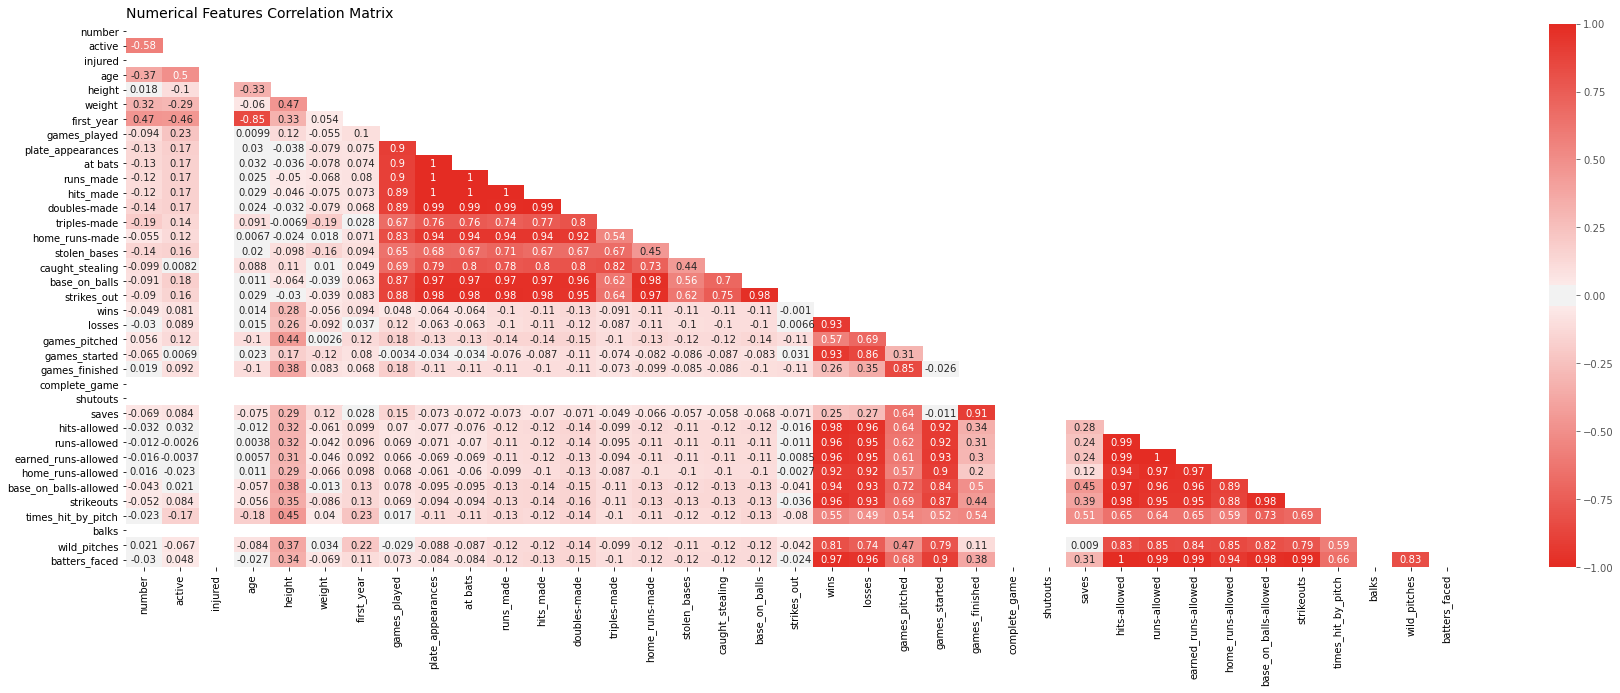

In [23]:
# Checking for correlations
# Cheacking for correlation:
# Numeric variables correlation
cmap = sns.diverging_palette(13, 13, s=90, n=5, as_cmap=True)
fig, ax = plt.subplots(figsize=(30,10))
style.use('ggplot')
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
ax = sns.heatmap(corr,mask=mask, annot=True, 
            cmap=cmap, vmin = -1, vmax = 1)
plt.title("Numerical Features Correlation Matrix", loc="left", fontsize=14)
plt.show()

In [24]:
df.head()

,number,name,country,active,injured,age,batting_side,throwing_hand,height,weight,birt_date,first_year,position,games_played,plate_appearances,at bats,runs_made,hits_made,doubles-made,triples-made,home_runs-made,stolen_bases,caught_stealing,base_on_balls,strikes_out,wins,losses,games_pitched,games_started,games_finished,complete_game,shutouts,saves,innings_pitched,hits-allowed,runs-allowed,earned_runs-allowed,home_runs-allowed,base_on_balls-allowed,strikeouts,times_hit_by_pitch,balks,wild_pitches,batters_faced
0,23,Zac Gallen,US,1,0,23,R,R,74,191,1995-08-03,2014,P,8,13,9,1,1,0,0,0,0,0,0,3,2,3,8,8,0,0,0,0,43.2,37,14,14,5,18,53,2,0,2,183
1,48,Corbin Martin,US,1,0,23,R,R,74,228,1995-12-28,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,50,Yoan López,CU,1,0,26,R,R,75,205,1993-01-02,2011,P,65,0,0,0,0,0,0,0,0,0,0,0,2,7,70,0,13,0,0,1,60.2,52,27,23,11,17,42,0,0,1,246
3,38,Robbie Ray,US,1,0,27,L,L,74,215,1991-10-01,2010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,29,Merrill Kelly,US,1,0,30,R,R,74,210,1988-10-14,2010,P,30,60,52,3,1,0,0,0,0,0,2,25,13,14,32,32,0,0,0,0,183.1,184,95,90,29,57,158,2,0,4,777


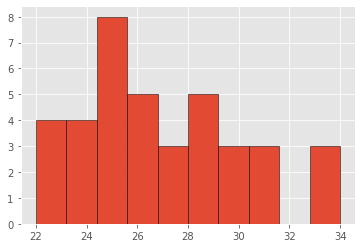

In [25]:
df['age'].hist(edgecolor='k')

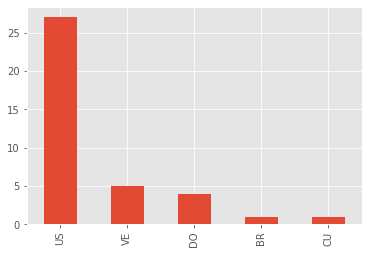

In [26]:
df['country'].value_counts().plot.bar()

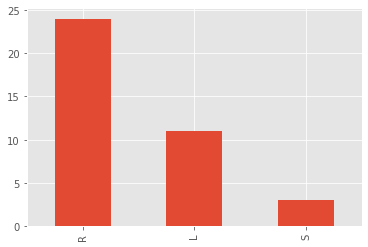

In [27]:
df['batting_side'].value_counts().plot.bar()

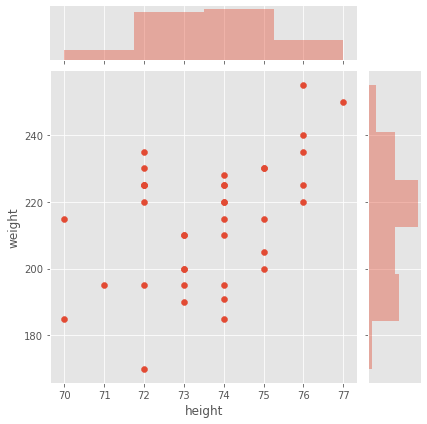

In [31]:
df['batters_faced']
df['runs-allowed']
sns.jointplot(x='height', y='weight', data =df)

In [37]:
df.head()

,number,name,country,active,injured,age,batting_side,throwing_hand,height,weight,birt_date,first_year,position,games_played,plate_appearances,at bats,runs_made,hits_made,doubles-made,triples-made,home_runs-made,stolen_bases,caught_stealing,base_on_balls,strikes_out,wins,losses,games_pitched,games_started,games_finished,complete_game,shutouts,saves,innings_pitched,hits-allowed,runs-allowed,earned_runs-allowed,home_runs-allowed,base_on_balls-allowed,strikeouts,times_hit_by_pitch,balks,wild_pitches,batters_faced
0,23,Zac Gallen,US,1,0,23,R,R,74,191,1995-08-03,2014,P,8,13,9,1,1,0,0,0,0,0,0,3,2,3,8,8,0,0,0,0,43.2,37,14,14,5,18,53,2,0,2,183
1,48,Corbin Martin,US,1,0,23,R,R,74,228,1995-12-28,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,50,Yoan López,CU,1,0,26,R,R,75,205,1993-01-02,2011,P,65,0,0,0,0,0,0,0,0,0,0,0,2,7,70,0,13,0,0,1,60.2,52,27,23,11,17,42,0,0,1,246
3,38,Robbie Ray,US,1,0,27,L,L,74,215,1991-10-01,2010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,29,Merrill Kelly,US,1,0,30,R,R,74,210,1988-10-14,2010,P,30,60,52,3,1,0,0,0,0,0,2,25,13,14,32,32,0,0,0,0,183.1,184,95,90,29,57,158,2,0,4,777
